In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
from dsb2018 import Dsb2018Dataset


%matplotlib inline

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Root directory of the project
ROOT_DIR = os.getcwd()

/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "dsb2018_logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Size of train data:603
Size of val data:67


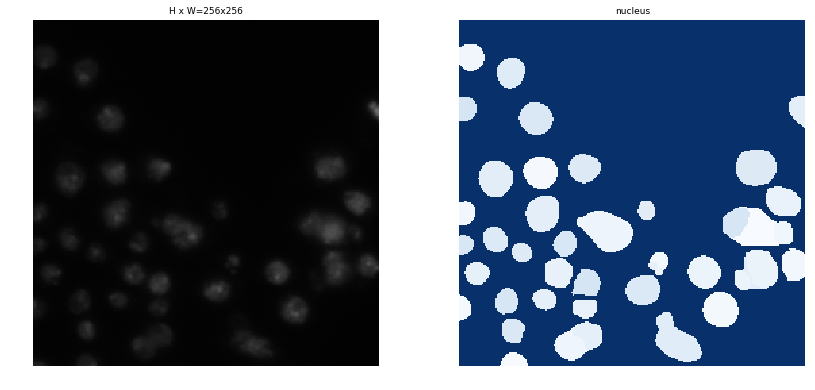

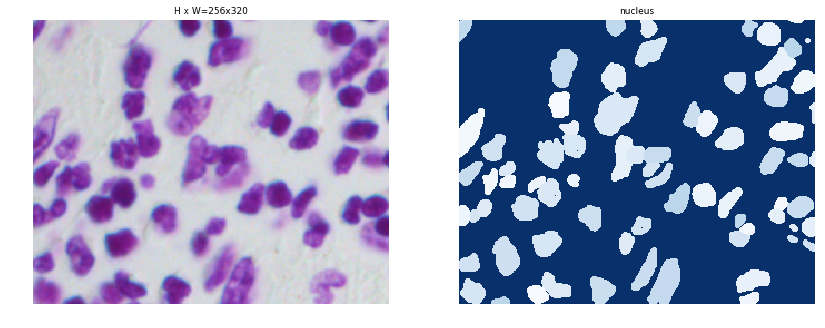

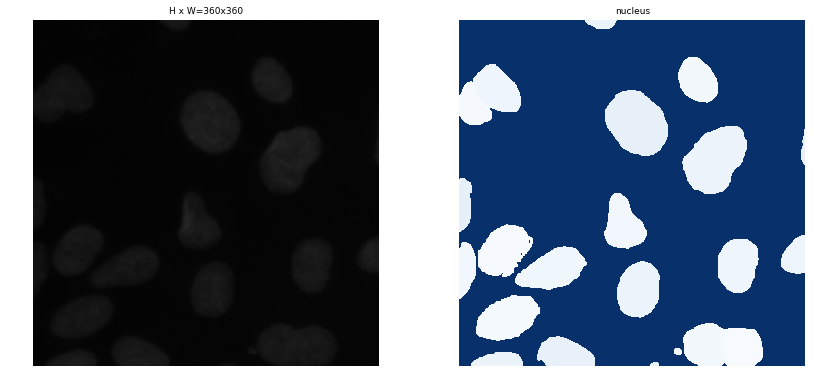

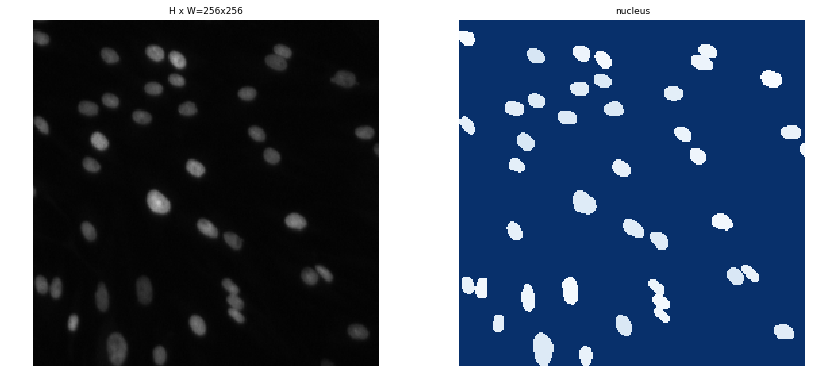

In [3]:
# Training dataset
train_data = Dsb2018Dataset()
train_data.load_dsb2018('../DSB2018')
train_data.prepare()

val_data = Dsb2018Dataset()
val_data.load_dsb2018('../DSB2018', is_trainset=False)
val_data.prepare()
print("Size of train data:{}".format(len(train_data.image_ids)))
print("Size of val data:{}".format(len(val_data.image_ids)))


#Load and display random samples
image_ids = np.random.choice(train_data.image_ids, 2)
for image_id in image_ids:
    image = train_data.load_image(image_id)
    mask, class_ids = train_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_data.class_names, limit=1)
    
    
#Load and display random samples
image_ids = np.random.choice(val_data.image_ids, 2)
for image_id in image_ids:
    image = val_data.load_image(image_id)
    mask, class_ids = val_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, val_data.class_names, limit=1)


In [20]:
class Dsb2018Config(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "DSB2018"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    USE_MINI_MASK = True
    
    #MINI_MASK_SHAPE = (112, 112)  # (height, width) of the mini-mask


    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64,128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 152

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 18
    
    #DETECTION_MIN_CONFIDENCE = 0.8

config = Dsb2018Config()

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(train_data, val_data,
            learning_rate=config.LEARNING_RATE,
            epochs=400,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180218T1343/mask_rcnn_dsb2018_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/400


/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 23/152 [===>..........................] - ETA: 5:34 - loss: 4.0490 - rpn_class_loss: 0.8046 - rpn_bbox_loss: 1.6022 - mrcnn_class_loss: 0.1823 - mrcnn_bbox_loss: 0.8232 - mrcnn_mask_loss: 0.6367

In [18]:
class InferenceConfig(Dsb2018Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]
model_path = '/home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180217T2343/mask_rcnn_dsb2018_0098.h5'
print(model_path)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180217T2343/mask_rcnn_dsb2018_0098.h5
Loading weights from  /home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180217T2343/mask_rcnn_dsb2018_0098.h5


/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


original_image           shape: (512, 512, 3)         min:    0.00000  max:  222.00000
image_meta               shape: (10,)                 min:    0.00000  max:  696.00000
gt_class_id              shape: (38,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (38, 4)               min:    0.00000  max:  512.00000
gt_mask                  shape: (512, 512, 38)        min:    0.00000  max:  255.00000


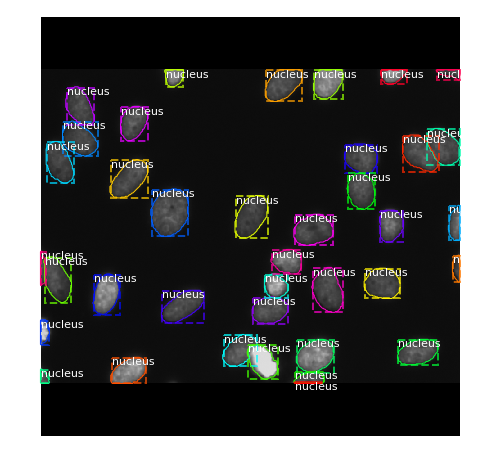

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  222.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  118.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


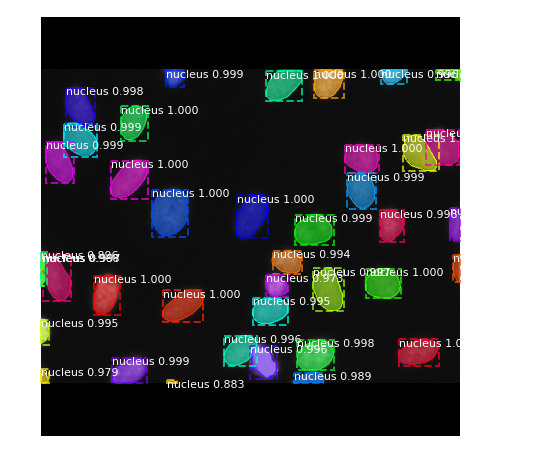

In [15]:
# Test on a random train image
image_id = random.choice(train_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(train_data, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_data.class_names, figsize=(8, 8))

# mask, class_ids = train_data.load_mask(image_id)
# visualize.display_top_masks(original_image, mask, class_ids, train_data.class_names, limit=1)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            train_data.class_names, r['scores'], ax=get_ax())

/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  512.00000
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:    0.00000  max:   90.00000
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:  255.00000
img size:(512, 512, 3)
mask size:(512, 512, 1)


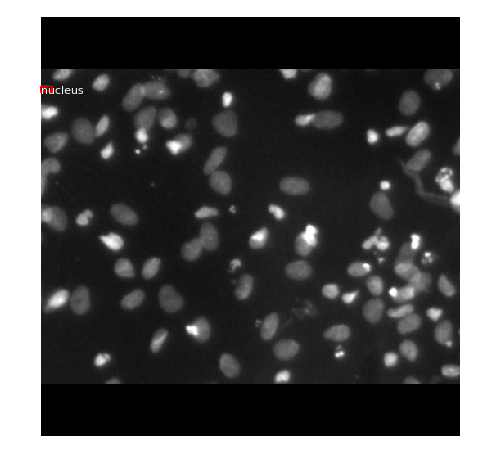

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


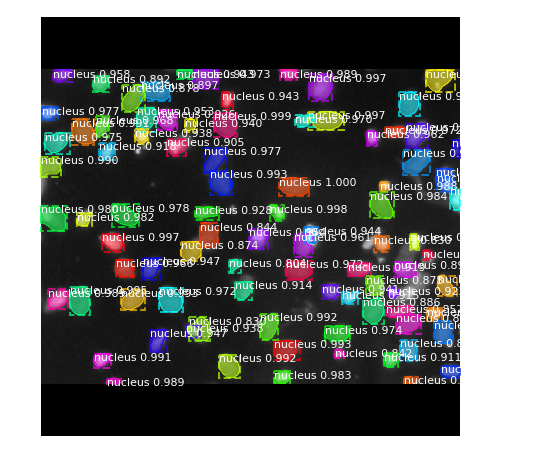

In [16]:
# Test on a random test image
image_id = random.choice(val_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_data, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

print("img size:{}".format(original_image.shape))
print("mask size:{}".format(gt_mask.shape))

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            val_data.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            val_data.class_names, r['scores'], ax=get_ax())



original shape:(519, 253, 3)
resized shape:(512, 512, 3), scale:0.9865125240847784, padding:[(0, 0), (131, 131), (0, 0)]


/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


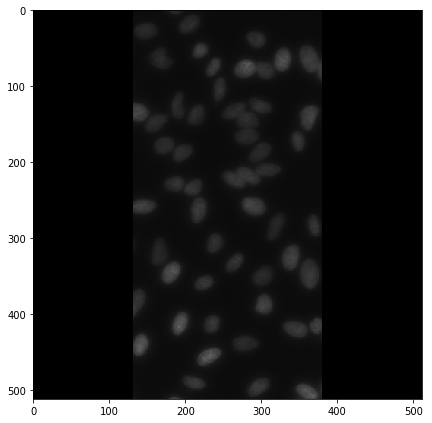

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:   98.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   -5.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


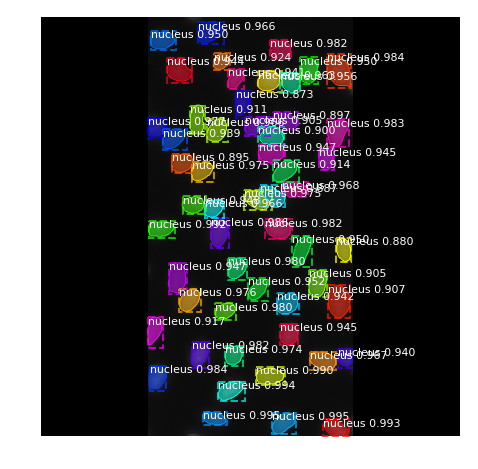

mask shape:(512, 512, 1)
(505, 767, 1)


In [12]:
import json
from skimage.io import imread, imshow, imread_collection, concatenate_images
import matplotlib.pyplot as plt
from utils import resize_image, resize_mask

def load_testset(pathname):
    dictionaries = []
    with open(pathname) as data:
        dictionaries = json.load(data)
    return dictionaries

base_dir = '../DSB2018'

test_set = load_testset(os.path.join(base_dir, 'test.json'))
# Test on a random test image

test = test_set[random.randint(0, len(test_set)-1)]
test_img = imread(os.path.join(base_dir, 'images', test['image']['pathname']))
print("original shape:{}".format(test_img.shape))
test_img,_, scale,padding = resize_image(test_img, min_dim=512,max_dim=512, padding=True)
print("resized shape:{}, scale:{}, padding:{}".format(test_img.shape,scale, padding))
plt.figure(figsize=(6,6))
imshow(test_img)
plt.show()

results = model.detect([test_img], verbose=1)
r = results[0]
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            train_data.class_names, r['scores'], ax=get_ax())
first_mask = r['masks'][:,:,0]
first_mask = np.expand_dims(first_mask, axis=2)
print('mask shape:{}'.format(first_mask.shape))
print(resize_mask(first_mask, scale, padding).shape)

In [19]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(val_data.image_ids, 65)
APs = []
for image_id in val_data.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(val_data, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP:  0.7996558595039288
